# PyTorch Classification Example

In this notebook, we're going to use ResNet-18 implemented in pyTorch to classify the 5-particle example training data.

This tutorial is meant to walk through some of the necessary steps to load images stored in LArCV files and train a network.  For more details on how to use pytorch, refer to the official pytorch tutorials.

This notebook will try to be self-contained in terms of code. 
However, you can find the code separated into different files in the following repositories

* [LArCVDataset](https://github.com/DeepLearnPhysics/larcvdataset): concrete instance of pytorch Dataset class written for LArCV2 IO
* [pytorch-classification-example](https://github.com/DeepLearnPhysics/pytorch-resnet-example): many of the files and scripts found in this tutorial
* [pytorch resnet implementation](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py): is where we get our implementation with some slight modifications
* [pytorch ImageNet training example](https://github.com/pytorch/examples/blob/master/imagenet/main.py): is where we get the methods for training, again, with some slight modifications

You will also need the training data. Go to the [open data page](http://deeplearnphysics.org/DataChallenge/) and download the either the 5k or 50k training/validation samples.


In [1]:
# Import our modules

# python
import os,sys
import shutil
import time
import traceback

# numpy
import numpy as np

# torch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# ROOT/LArCV
import ROOT
from larcv import larcv

%matplotlib notebook
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.12/04


## Set the GPU to use

In [2]:
torch.cuda.device( 1 )

# Setup Data IO

## Location of data on your local machine

Set the path to the data files in this block.

In [3]:
path_to_train_data="/home/taritree/working/dlphysics/testset/train_50k.root"
path_to_test_data="/home/taritree/working/dlphysics/testset/test_40k.root"
if not os.path.exists(path_to_train_data):
    print "Could not find the training data file."
if not os.path.exists(path_to_test_data):
    print "Could not find the validation data file."

## Define LArCVDataset

First, we define a class that will load our data. There are many ways to do this. We create a concrete instance of pytorch's `Dataset` class, which can be used in the `DataLoader` class (which we do not use).

In [4]:
# from: https://github.com/deeplearnphysics/larcvdataset

larcv.PSet # touch this to force libBase to load, which has CreatePSetFromFile
from larcv.dataloader2 import larcv_threadio
from torch.utils.data import Dataset

class LArCVDataset(Dataset):
    """ LArCV data set interface for PyTorch"""

    def __init__( self, cfg, fillername, verbosity=0, loadallinmem=False, randomize_inmem_data=True, max_inmem_events=-1 ):
        self.verbosity = verbosity
        self.batchsize = None
        self.randomize_inmem_data = randomize_inmem_data
        self.max_inmem_events = max_inmem_events
        self.loadallinmem = loadallinmem
        self.cfg = cfg  

        # we setup the larcv threadfiller class, which handles io from larcv files
        # this follows steps from larcv tutorials
        
        # setup cfg dictionary needed for larcv_threadio      
        self.filler_cfg = {}
        self.filler_cfg["filler_name"] = fillername
        self.filler_cfg["verbosity"]   = self.verbosity
        self.filler_cfg["filler_cfg"]  = self.cfg
        if not os.path.exists(self.cfg):
            raise ValueError("Could not find filler configuration file: %s"%(self.cfg))

        # we read the first line of the config file, which should have name of config parameter set
        linepset = open(self.cfg,'r').readlines()
        self.cfgname = linepset[0].split(":")[0].strip()
        
        # we load the pset ourselves, as we want access to values in 'ProcessName' list
        # will use these as the names of the data products loaded. store in self.datalist
        self.pset = larcv.CreatePSetFromFile(self.cfg,self.cfgname).get("larcv::PSet")(self.cfgname)
        datastr_v = self.pset.get("std::vector<std::string>")("ProcessName")
        self.datalist = []
        for i in range(0,datastr_v.size()):
            self.datalist.append(datastr_v[i])
        
        # finally, configure io
        self.io = larcv_threadio()        
        self.io.configure(self.filler_cfg)
        
        if self.loadallinmem:
            self._loadinmem()

    def __len__(self):
        if not self.loadallinmem:
            return int(self.io.fetch_n_entries())
        else:
            return int(self.alldata[self.datalist[0]].shape[0])

    def __getitem__(self, idx):
        if not self.loadallinmem:
            self.io.next()
            out = {}
            for name in self.datalist:
                out[name] = self.io.fetch_data(name).data()
        else:
            indices = np.random.randint(len(self),size=self.batchsize)
            out = {}
            for name in self.datalist:
                out[name] = np.zeros( (self.batchsize,self.alldata[name].shape[1]), self.alldata[name].dtype )
                for n,idx in enumerate(indices):
                    out[name][n,:] = self.alldata[name][idx,:]
        return out
        
    def __str__(self):
        return dumpcfg()
    
    def _loadinmem(self):
        """load data into memory"""
        nevents = int(self.io.fetch_n_entries())
        if self.max_inmem_events>0 and nevents>self.max_inmem_events:
            nevents = self.max_inmem_events

        print "Attempting to load all ",nevents," into memory. good luck"
        start = time.time()

        # start threadio
        self.start(1)

        # get one data element to get shape
        self.io.next()
        firstout = {}
        for name in self.datalist:
            firstout[name] = self.io.fetch_data(name).data()
            self.alldata = {}
        for name in self.datalist:
            self.alldata[name] = np.zeros( (nevents,firstout[name].shape[1]), firstout[name].dtype )
            self.alldata[name][0] = firstout[name][0,:]
        for i in range(1,nevents):
            self.io.next()
            if i%100==0:
                print "loading event %d of %d"%(i,nevents)
            for name in self.datalist:
                out = self.io.fetch_data(name).data()
                self.alldata[name][i,:] = out[0,:]

        print "elapsed time to bring data into memory: ",time.time()-start,"sec"
        self.stop()

    def start(self,batchsize):
        """exposes larcv_threadio::start which is used to start the thread managers"""
        self.batchsize = batchsize
        self.io.start_manager(self.batchsize)

    def stop(self):
        """ stops the thread managers"""
        self.io.stop_manager()

    def dumpcfg(self):
        """dump the configuration file to a string"""
        print open(self.cfg).read()
        


## Write configuration files for the LArCV ThreadFiller class

We define the configurations in this block, then write to file. We will load the files later when we create LArCVDataset instances for both the training and test data.

A note: the configurations need to have a separate name. Also, the `ProcessNames` have to be different. This is because of the way the threads are managed.

In [5]:
train_cfg="""ThreadProcessor: {
  Verbosity:3
  NumThreads: 3
  NumBatchStorage: 3
  RandomAccess: true
  InputFiles: ["%s"]  
  ProcessName: ["image","label"]
  ProcessType: ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessList: {
    image: {
      Verbosity:3
      ImageProducer: "data"
      Channels: [2]
      EnableMirror: true
    }
    label: {
      Verbosity:3
      ParticleProducer: "mctruth"
      PdgClassList: [2212,11,211,13,22]
    }
  }
}
"""%(path_to_train_data)

test_cfg="""ThreadProcessorTest: {
  Verbosity:3
  NumThreads: 2
  NumBatchStorage: 2
  RandomAccess: true
  InputFiles: ["%s"]
  ProcessName: ["imagetest","labeltest"]
  ProcessType: ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessList: {
    imagetest: {
      Verbosity:3
      ImageProducer: "data"
      Channels: [2]
      EnableMirror: false
    }
    labeltest: {
      Verbosity:3
      ParticleProducer: "mctruth"
      PdgClassList: [2212,11,211,13,22]
    }
  }
}
"""%(path_to_test_data)

train_cfg_out = open("train_dataloader.cfg",'w')
print >> train_cfg_out,train_cfg
train_cfg_out.close()

test_cfg_out  = open("valid_dataloader.cfg",'w')
print >> test_cfg_out,test_cfg
test_cfg_out.close()

# Setup Network

## Define network

We use ResNet-18 as implemented in the torchvision module.  We reproduce it here and make a slight modification: we change the number of input channels from 3 to 1.  The original resnet expects an RGB image.  For our example, we only use the image from one plane from our hypothetical LAr TPC detector.

Original can be found [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).

In [6]:
import torch.nn as nn
import math

# define convolution without bias that we will use throughout the network
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# implements one ResNet unit
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# define the network. It provides options for 
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, input_channels=3):
        """
        inputs
        ------
        block: type of resnet unit
        layers: list of 4 ints. defines number of basic block units in each set of resnet units
        num_classes: output classes
        input_channels: number of channels in input images
        """
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # had to change stride of avgpool from original from 1 to 2
        self.avgpool = nn.AvgPool2d(7, stride=2)

        # I've added dropout to the network
        self.dropout = nn.Dropout2d(p=0.5,inplace=True)

        #print "block.expansion=",block.expansion                                                                                                                                                           
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        #print "avepool: ",x.data.shape                                                                                                                                                                     
        x = x.view(x.size(0), -1)
        #print "view: ",x.data.shape                                                                                                                                                                        
        x = self.fc(x)

        return x


    
# define a helper function for ResNet-18
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.                                                                                                                                                                        
                                                                                                                                                                                                            
    Args:                                                                                                                                                                                                   
        pretrained (bool): If True, returns a model pre-trained on ImageNet                                                                                                                                 
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


## Create instance of network

In [7]:
model = resnet18(pretrained=False,num_classes=5, input_channels=1)
model.cuda()

ResNet(
  (conv1): Conv2d (1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

## Define loss function

In [8]:
criterion = nn.CrossEntropyLoss().cuda()

## Define optimizer and set training parameters

In [9]:
lr = 1.0e-3
momentum = 0.9
weight_decay = 1.0e-3
batchsize = 50
batchsize_valid = 500
start_epoch = 0
epochs      = 100
nbatches_per_iteration = 10000/batchsize
nbatches_per_valid     = 1000/batchsize_valid

# We use SGD
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)

# Define training and validation steps

We define functions and classes to help us perform training.

### Define an object that will help us track averages

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Training step

In [11]:
def train(train_loader, model, criterion, optimizer, nbatches, iteration, print_freq):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    format_time = AverageMeter()
    train_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode                                                                                                                                                                                  
    model.train()

    for i in range(0,nbatches):                                                                                                                                                   
        batchstart = time.time()

        end = time.time()
        data = train_loader[i]
        # measure data loading time                                                                                                                                                                         
        data_time.update(time.time() - end)

        end = time.time()
        img = data["image"]
        lbl = data["label"]
        img_np = np.zeros( (img.shape[0], 1, 256, 256), dtype=np.float32 )
        lbl_np = np.zeros( (lbl.shape[0] ), dtype=np.int )
        # batch loop                                                                                                                                                                                        
        for j in range(img.shape[0]):
            imgtmp = img[j].reshape( (256,256) )
            img_np[j,0,:,:] = padandcropandflip(imgtmp) # data augmentation                                                                                                                                 
            lbl_np[j] = np.argmax(lbl[j])
        input  = torch.from_numpy(img_np).cuda()
        target = torch.from_numpy(lbl_np).cuda()

        # measure data formatting time                                                                                                                                                                      
        format_time.update(time.time() - end)

        # convert into torch variable
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output                                                                                                                                                                                    
        end = time.time()
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss                                                                                                                                                                  
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        
        # compute gradient and do SGD step                                                                                                                                                                  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time.update(time.time()-end)

        # measure elapsed time                                                                                                                                                                              
        batch_time.update(time.time() - batchstart)
        
        if print_freq>0 and i % print_freq == 0:
            status = (iteration,i,nbatches,
                      batch_time.val,batch_time.avg,
                      data_time.val,data_time.avg,
                      format_time.val,format_time.avg,
                      train_time.val,train_time.avg,
                      losses.val,losses.avg,
                      top1.val,top1.avg)
            print "Iteration: [%d][%d/%d]\tTime %.3f (%.3f)\tData %.3f (%.3f)\tFormat %.3f (%.3f)\tTrain %.3f (%.3f)\tLoss %.3f (%.3f)\tPrec@1 %.3f (%.3f)"%status
            
    return losses.avg,top1.avg

### Validation step

Here we process the test data and accumilate the accuracy.

In [12]:
def validate(val_loader, model, criterion, nbatches, print_freq):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode                                                                                                                                                                               
    model.eval()

    end = time.time()
    for i in range(0,nbatches):
        data = val_loader[i]
        img = data["imagetest"]
        lbl = data["labeltest"]
        img_np = np.zeros( (img.shape[0], 1, 256, 256), dtype=np.float32 )
        lbl_np = np.zeros( (lbl.shape[0] ), dtype=np.int )
        for j in range(img.shape[0]):
            img_np[j,0,:,:] = img[j].reshape( (256,256) )
            lbl_np[j] = np.argmax(lbl[j])
        input  = torch.from_numpy(img_np).cuda()
        target = torch.from_numpy(lbl_np).cuda()

        # convert into torch variable
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output                                                                                                                                                                                    
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss                                                                                                                                                                  
        prec1 = accuracy(output.data, target, topk=(1,))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time                                                                                                                                                                              
        batch_time.update(time.time() - end)
        end = time.time()
        if print_freq>0 and i % print_freq == 0:
            status = (i,nbatches,batch_time.val,batch_time.avg,losses.val,losses.avg,top1.val,top1.avg)
            print "Test: [%d/%d]\tTime %.3f (%.3f)\tLoss %.3f (%.3f)\tPrec@1 %.3f (%.3f)"%status
 
    print "Test:Result* Prec@1 %.3f\tLoss %.3f"%(top1.avg,losses.avg)
    
    return float(top1.avg),float(losses.avg)

### utility functions

In [13]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    #lr = lr * (0.5 ** (epoch // 300))                                                                                                                                                                      
    lr = lr
    #lr = lr*0.992                                                                                                                                                                                          
    #print "adjust learning rate to ",lr                                                                                                                                                                    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def dump_lr_schedule( startlr, numepochs ):
    for epoch in range(0,numepochs):
        lr = startlr*(0.5**(epoch//300))
        if epoch%10==0:
            print "Epoch [%d] lr=%.3e"%(epoch,lr)
    print "Epoch [%d] lr=%.3e"%(epoch,lr)
    return

def padandcropandflip(npimg2d):
    imgpad  = np.zeros( (264,264), dtype=np.float32 )
    imgpad[4:256+4,4:256+4] = npimg2d[:,:]
    if np.random.rand()>0.5:
        imgpad = np.flip( imgpad, 0 )
    if np.random.rand()>0.5:
        imgpad = np.flip( imgpad, 1 )
    randx = np.random.randint(0,8)
    randy = np.random.randint(0,8)
    return imgpad[randx:randx+256,randy:randy+256]

def save_checkpoint(state, is_best, p, filename='checkpoint.pth.tar'):
    if p>0:
        filename = "checkpoint.%dth.tar"%(p)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


# Load the datasets and start data loading threads


### Training data

For the training data, we ask that all the data is loaded into memory. Since we need to get many, many batches to train the network, reducing the time to get a batch of images will pay off in the long run.

However, we first pay an upfront cost: this step takes a LONG time.

In [14]:
#capevents = 100 # for debugging, to keep the time this step takes to a minimum
#iotrain = LArCVDataset("train_dataloader.cfg", "ThreadProcessor", loadallinmem=True, max_inmem_events=capevents)
iotrain = LArCVDataset("train_dataloader.cfg", "ThreadProcessor", loadallinmem=True)
iotrain.start(batchsize)

Attempting to load all  50000  into memory. good luck
loading event 100 of 50000
loading event 200 of 50000
loading event 300 of 50000
loading event 400 of 50000
loading event 500 of 50000
loading event 600 of 50000
loading event 700 of 50000
loading event 800 of 50000
loading event 900 of 50000
loading event 1000 of 50000
loading event 1100 of 50000
loading event 1200 of 50000
loading event 1300 of 50000
loading event 1400 of 50000
loading event 1500 of 50000
loading event 1600 of 50000
loading event 1700 of 50000
loading event 1800 of 50000
loading event 1900 of 50000
loading event 2000 of 50000
loading event 2100 of 50000
loading event 2200 of 50000
loading event 2300 of 50000
loading event 2400 of 50000
loading event 2500 of 50000
loading event 2600 of 50000
loading event 2700 of 50000
loading event 2800 of 50000
loading event 2900 of 50000
loading event 3000 of 50000
loading event 3100 of 50000
loading event 3200 of 50000
loading event 3300 of 50000
loading event 3400 of 50000
loa

loading event 28600 of 50000
loading event 28700 of 50000
loading event 28800 of 50000
loading event 28900 of 50000
loading event 29000 of 50000
loading event 29100 of 50000
loading event 29200 of 50000
loading event 29300 of 50000
loading event 29400 of 50000
loading event 29500 of 50000
loading event 29600 of 50000
loading event 29700 of 50000
loading event 29800 of 50000
loading event 29900 of 50000
loading event 30000 of 50000
loading event 30100 of 50000
loading event 30200 of 50000
loading event 30300 of 50000
loading event 30400 of 50000
loading event 30500 of 50000
loading event 30600 of 50000
loading event 30700 of 50000
loading event 30800 of 50000
loading event 30900 of 50000
loading event 31000 of 50000
loading event 31100 of 50000
loading event 31200 of 50000
loading event 31300 of 50000
loading event 31400 of 50000
loading event 31500 of 50000
loading event 31600 of 50000
loading event 31700 of 50000
loading event 31800 of 50000
loading event 31900 of 50000
loading event 

Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class thread
Error in <CreateRealData>: Cannot find data member # 0 of class thread for parent larcv::ThreadProcessor!


### Validation data

For the validation data, we do not load data into memory all at once. We will use the validation only periodically, in between many training steps. During those training steps, the thread filler will load data into memory.

In [15]:
iovalid = LArCVDataset("valid_dataloader.cfg", "ThreadProcessorTest")
iovalid.start(batchsize_valid)

 setting verbosity 3


# Training Loop

For each iteration of the training loop, we
* set the learning rate
* perform a training iteration which involves forward and backward passes for the number of batches set in `nbatches_per_iteration` 
* run a validation iteration over `nbatches_per_valid`
* for both the training and validation iterations, we save the average loss and average accuracy over the batches. Values are stored in a numpy array
* we update the plot the training versus validation loss
* every 10 epochs (i.e. 50 iterations), we save the state of the model and the optimizer

<IPython.core.display.Javascript object>


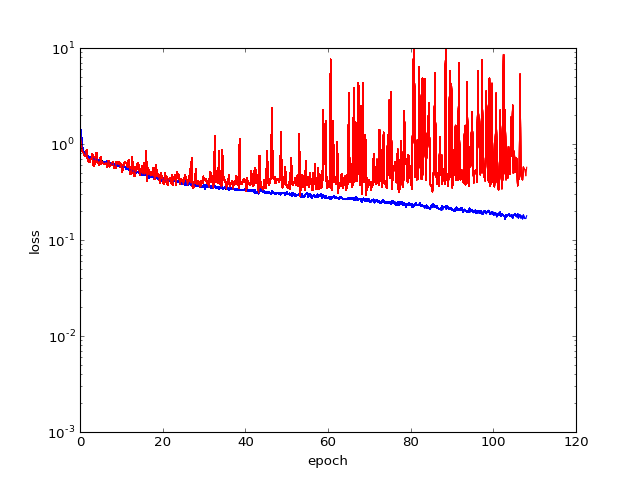

Epoch [0]: lr=1.000e-03
Epoch [0] train aveloss=1.524 aveacc=32.250
Test:Result* Prec@1 39.600	Loss 1.395
Test[0]:Result* Prec@1 39.600	Loss 1.395
Epoch [1]: lr=1.000e-03
Epoch [1] train aveloss=1.330 aveacc=43.060
Test:Result* Prec@1 55.000	Loss 1.127
Test[1]:Result* Prec@1 55.000	Loss 1.127
Epoch [2]: lr=1.000e-03
Epoch [2] train aveloss=1.091 aveacc=52.370
Test:Result* Prec@1 56.900	Loss 0.959
Test[2]:Result* Prec@1 56.900	Loss 0.959
Epoch [3]: lr=1.000e-03
Epoch [3] train aveloss=0.916 aveacc=59.360
Test:Result* Prec@1 60.700	Loss 0.839
Test[3]:Result* Prec@1 60.700	Loss 0.839
Epoch [4]: lr=1.000e-03
Epoch [4] train aveloss=0.843 aveacc=61.250
Test:Result* Prec@1 60.900	Loss 0.824
Test[4]:Result* Prec@1 60.900	Loss 0.824
Epoch [5]: lr=1.000e-03
Epoch [5] train aveloss=0.818 aveacc=61.550
Test:Result* Prec@1 63.500	Loss 0.777
Test[5]:Result* Prec@1 63.500	Loss 0.777
Epoch [6]: lr=1.000e-03
Epoch [6] train aveloss=0.799 aveacc=62.180
Test:Result* Prec@1 62.400	Loss 0.755
Test[6]:Resu

Epoch [55] train aveloss=0.567 aveacc=74.910
Test:Result* Prec@1 69.200	Loss 0.640
Test[55]:Result* Prec@1 69.200	Loss 0.640
Epoch [56]: lr=1.000e-03
Epoch [56] train aveloss=0.552 aveacc=75.510
Test:Result* Prec@1 71.900	Loss 0.639
Test[56]:Result* Prec@1 71.900	Loss 0.639
Epoch [57]: lr=1.000e-03
Epoch [57] train aveloss=0.552 aveacc=75.970
Test:Result* Prec@1 76.200	Loss 0.581
Test[57]:Result* Prec@1 76.200	Loss 0.581
Epoch [58]: lr=1.000e-03
Epoch [58] train aveloss=0.552 aveacc=76.070
Test:Result* Prec@1 73.300	Loss 0.633
Test[58]:Result* Prec@1 73.300	Loss 0.633
Epoch [59]: lr=1.000e-03
Epoch [59] train aveloss=0.544 aveacc=76.170
Test:Result* Prec@1 69.600	Loss 0.683
Test[59]:Result* Prec@1 69.600	Loss 0.683
Epoch [60]: lr=1.000e-03
Epoch [60] train aveloss=0.538 aveacc=76.280
Test:Result* Prec@1 75.200	Loss 0.554
Test[60]:Result* Prec@1 75.200	Loss 0.554
Epoch [61]: lr=1.000e-03
Epoch [61] train aveloss=0.540 aveacc=76.620
Test:Result* Prec@1 78.400	Loss 0.486
Test[61]:Result* 

Epoch [110]: lr=1.000e-03
Epoch [110] train aveloss=0.417 aveacc=83.530
Test:Result* Prec@1 84.000	Loss 0.396
Test[110]:Result* Prec@1 84.000	Loss 0.396
Epoch [111]: lr=1.000e-03
Epoch [111] train aveloss=0.410 aveacc=83.790
Test:Result* Prec@1 80.100	Loss 0.473
Test[111]:Result* Prec@1 80.100	Loss 0.473
Epoch [112]: lr=1.000e-03
Epoch [112] train aveloss=0.408 aveacc=83.980
Test:Result* Prec@1 85.900	Loss 0.371
Test[112]:Result* Prec@1 85.900	Loss 0.371
Epoch [113]: lr=1.000e-03
Epoch [113] train aveloss=0.407 aveacc=83.940
Test:Result* Prec@1 81.000	Loss 0.452
Test[113]:Result* Prec@1 81.000	Loss 0.452
Epoch [114]: lr=1.000e-03
Epoch [114] train aveloss=0.415 aveacc=84.100
Test:Result* Prec@1 83.100	Loss 0.423
Test[114]:Result* Prec@1 83.100	Loss 0.423
Epoch [115]: lr=1.000e-03
Epoch [115] train aveloss=0.409 aveacc=84.270
Test:Result* Prec@1 81.500	Loss 0.472
Test[115]:Result* Prec@1 81.500	Loss 0.472
Epoch [116]: lr=1.000e-03
Epoch [116] train aveloss=0.401 aveacc=84.350
Test:Resul

Epoch [164]: lr=1.000e-03
Epoch [164] train aveloss=0.360 aveacc=86.050
Test:Result* Prec@1 85.000	Loss 0.399
Test[164]:Result* Prec@1 85.000	Loss 0.399
Epoch [165]: lr=1.000e-03
Epoch [165] train aveloss=0.345 aveacc=86.680
Test:Result* Prec@1 83.200	Loss 0.423
Test[165]:Result* Prec@1 83.200	Loss 0.423
Epoch [166]: lr=1.000e-03
Epoch [166] train aveloss=0.359 aveacc=86.010
Test:Result* Prec@1 84.800	Loss 0.414
Test[166]:Result* Prec@1 84.800	Loss 0.414
Epoch [167]: lr=1.000e-03
Epoch [167] train aveloss=0.349 aveacc=86.860
Test:Result* Prec@1 85.100	Loss 0.396
Test[167]:Result* Prec@1 85.100	Loss 0.396
Epoch [168]: lr=1.000e-03
Epoch [168] train aveloss=0.342 aveacc=86.870
Test:Result* Prec@1 75.500	Loss 0.839
Test[168]:Result* Prec@1 75.500	Loss 0.839
Epoch [169]: lr=1.000e-03
Epoch [169] train aveloss=0.359 aveacc=86.240
Test:Result* Prec@1 86.100	Loss 0.380
Test[169]:Result* Prec@1 86.100	Loss 0.380
Epoch [170]: lr=1.000e-03
Epoch [170] train aveloss=0.348 aveacc=86.410
Test:Resul

Epoch [218]: lr=1.000e-03
Epoch [218] train aveloss=0.341 aveacc=86.690
Test:Result* Prec@1 84.300	Loss 0.410
Test[218]:Result* Prec@1 84.300	Loss 0.410
Epoch [219]: lr=1.000e-03
Epoch [219] train aveloss=0.326 aveacc=87.380
Test:Result* Prec@1 85.500	Loss 0.357
Test[219]:Result* Prec@1 85.500	Loss 0.357
Epoch [220]: lr=1.000e-03
Epoch [220] train aveloss=0.329 aveacc=87.250
Test:Result* Prec@1 85.700	Loss 0.359
Test[220]:Result* Prec@1 85.700	Loss 0.359
Epoch [221]: lr=1.000e-03
Epoch [221] train aveloss=0.317 aveacc=88.040
Test:Result* Prec@1 87.800	Loss 0.331
Test[221]:Result* Prec@1 87.800	Loss 0.331
Epoch [222]: lr=1.000e-03
Epoch [222] train aveloss=0.325 aveacc=87.630
Test:Result* Prec@1 87.000	Loss 0.351
Test[222]:Result* Prec@1 87.000	Loss 0.351
Epoch [223]: lr=1.000e-03
Epoch [223] train aveloss=0.319 aveacc=87.400
Test:Result* Prec@1 83.100	Loss 0.422
Test[223]:Result* Prec@1 83.100	Loss 0.422
Epoch [224]: lr=1.000e-03
Epoch [224] train aveloss=0.309 aveacc=88.150
Test:Resul

Epoch [272]: lr=1.000e-03
Epoch [272] train aveloss=0.292 aveacc=88.680
Test:Result* Prec@1 87.200	Loss 0.330
Test[272]:Result* Prec@1 87.200	Loss 0.330
Epoch [273]: lr=1.000e-03
Epoch [273] train aveloss=0.302 aveacc=88.580
Test:Result* Prec@1 80.500	Loss 0.661
Test[273]:Result* Prec@1 80.500	Loss 0.661
Epoch [274]: lr=1.000e-03
Epoch [274] train aveloss=0.306 aveacc=88.310
Test:Result* Prec@1 84.500	Loss 0.402
Test[274]:Result* Prec@1 84.500	Loss 0.402
Epoch [275]: lr=1.000e-03
Epoch [275] train aveloss=0.305 aveacc=88.170
Test:Result* Prec@1 86.400	Loss 0.370
Test[275]:Result* Prec@1 86.400	Loss 0.370
Epoch [276]: lr=1.000e-03
Epoch [276] train aveloss=0.282 aveacc=89.160
Test:Result* Prec@1 85.200	Loss 0.454
Test[276]:Result* Prec@1 85.200	Loss 0.454
Epoch [277]: lr=1.000e-03
Epoch [277] train aveloss=0.290 aveacc=88.520
Test:Result* Prec@1 87.300	Loss 0.357
Test[277]:Result* Prec@1 87.300	Loss 0.357
Epoch [278]: lr=1.000e-03
Epoch [278] train aveloss=0.304 aveacc=88.470
Test:Resul

Epoch [326]: lr=1.000e-03
Epoch [326] train aveloss=0.268 aveacc=89.830
Test:Result* Prec@1 84.300	Loss 0.401
Test[326]:Result* Prec@1 84.300	Loss 0.401
Epoch [327]: lr=1.000e-03
Epoch [327] train aveloss=0.266 aveacc=89.880
Test:Result* Prec@1 84.300	Loss 0.401
Test[327]:Result* Prec@1 84.300	Loss 0.401
Epoch [328]: lr=1.000e-03
Epoch [328] train aveloss=0.275 aveacc=89.200
Test:Result* Prec@1 77.800	Loss 0.620
Test[328]:Result* Prec@1 77.800	Loss 0.620
Epoch [329]: lr=1.000e-03
Epoch [329] train aveloss=0.265 aveacc=89.970
Test:Result* Prec@1 88.000	Loss 0.355
Test[329]:Result* Prec@1 88.000	Loss 0.355
Epoch [330]: lr=1.000e-03
Epoch [330] train aveloss=0.273 aveacc=89.460
Test:Result* Prec@1 84.500	Loss 0.388
Test[330]:Result* Prec@1 84.500	Loss 0.388
Epoch [331]: lr=1.000e-03
Epoch [331] train aveloss=0.262 aveacc=89.980
Test:Result* Prec@1 58.200	Loss 3.863
Test[331]:Result* Prec@1 58.200	Loss 3.863
Epoch [332]: lr=1.000e-03
Epoch [332] train aveloss=0.276 aveacc=89.350
Test:Resul

Epoch [380]: lr=1.000e-03
Epoch [380] train aveloss=0.250 aveacc=90.560
Test:Result* Prec@1 80.200	Loss 0.544
Test[380]:Result* Prec@1 80.200	Loss 0.544
Epoch [381]: lr=1.000e-03
Epoch [381] train aveloss=0.237 aveacc=91.060
Test:Result* Prec@1 77.900	Loss 0.654
Test[381]:Result* Prec@1 77.900	Loss 0.654
Epoch [382]: lr=1.000e-03
Epoch [382] train aveloss=0.233 aveacc=91.340
Test:Result* Prec@1 84.200	Loss 0.405
Test[382]:Result* Prec@1 84.200	Loss 0.405
Epoch [383]: lr=1.000e-03
Epoch [383] train aveloss=0.233 aveacc=91.060
Test:Result* Prec@1 85.500	Loss 0.397
Test[383]:Result* Prec@1 85.500	Loss 0.397
Epoch [384]: lr=1.000e-03
Epoch [384] train aveloss=0.246 aveacc=90.690
Test:Result* Prec@1 74.700	Loss 0.882
Test[384]:Result* Prec@1 74.700	Loss 0.882
Epoch [385]: lr=1.000e-03
Epoch [385] train aveloss=0.249 aveacc=90.440
Test:Result* Prec@1 87.100	Loss 0.338
Test[385]:Result* Prec@1 87.100	Loss 0.338
Epoch [386]: lr=1.000e-03
Epoch [386] train aveloss=0.232 aveacc=91.100
Test:Resul

Epoch [434]: lr=1.000e-03
Epoch [434] train aveloss=0.211 aveacc=92.070
Test:Result* Prec@1 87.800	Loss 0.362
Test[434]:Result* Prec@1 87.800	Loss 0.362
Epoch [435]: lr=1.000e-03
Epoch [435] train aveloss=0.212 aveacc=92.080
Test:Result* Prec@1 73.100	Loss 1.183
Test[435]:Result* Prec@1 73.100	Loss 1.183
Epoch [436]: lr=1.000e-03
Epoch [436] train aveloss=0.213 aveacc=92.160
Test:Result* Prec@1 84.600	Loss 0.474
Test[436]:Result* Prec@1 84.600	Loss 0.474
Epoch [437]: lr=1.000e-03
Epoch [437] train aveloss=0.206 aveacc=91.960
Test:Result* Prec@1 78.800	Loss 0.770
Test[437]:Result* Prec@1 78.800	Loss 0.770
Epoch [438]: lr=1.000e-03
Epoch [438] train aveloss=0.225 aveacc=91.200
Test:Result* Prec@1 86.500	Loss 0.384
Test[438]:Result* Prec@1 86.500	Loss 0.384
Epoch [439]: lr=1.000e-03
Epoch [439] train aveloss=0.213 aveacc=92.270
Test:Result* Prec@1 82.400	Loss 0.554
Test[439]:Result* Prec@1 82.400	Loss 0.554
Epoch [440]: lr=1.000e-03
Epoch [440] train aveloss=0.223 aveacc=91.660
Test:Resul

Epoch [488]: lr=1.000e-03
Epoch [488] train aveloss=0.193 aveacc=92.980
Test:Result* Prec@1 84.700	Loss 0.456
Test[488]:Result* Prec@1 84.700	Loss 0.456
Epoch [489]: lr=1.000e-03
Epoch [489] train aveloss=0.201 aveacc=92.450
Test:Result* Prec@1 83.800	Loss 0.471
Test[489]:Result* Prec@1 83.800	Loss 0.471
Epoch [490]: lr=1.000e-03
Epoch [490] train aveloss=0.198 aveacc=92.670
Test:Result* Prec@1 84.700	Loss 0.413
Test[490]:Result* Prec@1 84.700	Loss 0.413
Epoch [491]: lr=1.000e-03
Epoch [491] train aveloss=0.189 aveacc=92.940
Test:Result* Prec@1 57.800	Loss 3.538
Test[491]:Result* Prec@1 57.800	Loss 3.538
Epoch [492]: lr=1.000e-03
Epoch [492] train aveloss=0.197 aveacc=92.670
Test:Result* Prec@1 72.700	Loss 1.395
Test[492]:Result* Prec@1 72.700	Loss 1.395
Epoch [493]: lr=1.000e-03
Epoch [493] train aveloss=0.196 aveacc=92.990
Test:Result* Prec@1 83.600	Loss 0.459
Test[493]:Result* Prec@1 83.600	Loss 0.459
Epoch [494]: lr=1.000e-03
Epoch [494] train aveloss=0.203 aveacc=92.570
Test:Resul

KeyboardInterrupt: 

In [16]:
best_prec1 = 0.0

# define plots
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(1.0e-3,10.0)
ax.set_yscale("log")

# iterations:
# there are 50k events in the training set
# we use 10k images per training iteration
# therefore, 1 epoch is 5 iterations
start_iteration = 5*start_epoch
end_iteration   = 5*epochs
num_iterations  = end_iteration - start_iteration
x = np.linspace(start_epoch,epochs,num_iterations)

# numpy arrays for loss and accuracy
y_train_loss = np.zeros(num_iterations)
y_train_acc  = np.zeros(num_iterations)
y_valid_loss = np.zeros(num_iterations)
y_valid_acc  = np.zeros(num_iterations)


for iiter in range(0,num_iterations):
    
    iteration = start_iteration + iiter
    epoch = float(iteration)/5.0
    
    # set the learning rate
    adjust_learning_rate(optimizer, iteration, lr)
    iterout = "Iteration [%d]: "%(iteration)
    for param_group in optimizer.param_groups:
        iterout += "lr=%.3e"%(param_group['lr'])
    print iterout

    # train for one iteration                                                                                                                                                                               
    try:
        train_ave_loss, train_ave_acc = train(iotrain, model, criterion, optimizer, 
                                              nbatches_per_iteration, iteration, -1)
    except Exception,e:
        print "Error in training routine!"
        print e.message
        print e.__class__.__name__
        traceback.print_exc(e)
        break
    print "Iteration [%d] train aveloss=%.3f aveacc=%.3f"%(iteration,
                                                           train_ave_loss,
                                                           train_ave_acc)
    y_train_loss[iiter] = train_ave_loss
    y_train_acc[iiter]  = train_ave_acc

    # evaluate on validation set                                                                                                                                                                        
    try:
        prec1,valid_loss = validate(iovalid, model, criterion, nbatches_per_valid, -1)
    except Exception,e:
        print "Error in validation routine!"
        print e.message
        print e.__class__.__name__
        traceback.print_exc(e)
        break
    print "Test[%d]:Result* Prec@1 %.3f\tLoss %.3f"%(iteration,prec1,valid_loss)
    y_valid_loss[iiter] = valid_loss
    y_valid_acc[iiter]  = prec1
        
    # plot up to current iteration
    ax.plot(x[:iiter+1],y_train_loss[:iiter+1],'b')
    ax.plot(x[:iiter+1],y_valid_loss[:iiter+1],'r')
    fig.canvas.draw()
    
    # remember best prec@1 and save checkpoint                                                                                                                                                          
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': iteration + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer' : optimizer.state_dict(),
    }, is_best, -1)
    if iteration%50==0:
        save_checkpoint({
            'epoch': iteration + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, False, iteration)


In [18]:
# once the training is over. stop the fillers
iotrain.stop()
iovalid.stop()

## Observations from training

For the first 30 epochs (150 iterations), the training is going well. The average loss for the training data (blue) and validation data (red) are dropping steadily and doing so together.

After epoch 30, the training loss keeps lowering.  However, the training and validation losses are separating. The validation loss stops improving and becomes very variable.    These are both hallmarks of overtraining.

Looking at the standard output, the accuracy of the validation gets stuck at about 85%.  This is expected with our training data. The 15% of events involves images where the labels are inaccurate. For example, a proton interacts with a nucleus producing a bunch of photons. Or a muon decays early into an electron.  Refer to the blog post about version 0.1.0 of the open training data. This means we probably hit the accuracy limit.

This is why we saved a checkpoint every 50 iterations.  We can use the model saved at epoch 30.  In a subsequent post, we'll look at the performance of that model.